# Creator of worlds for the dissertation

The dissertation is dealing with trajectory planning for quadrotor drone. The planning is dealt as Optimal Control Problem that is approached with Pseudospectral multisegment collocation method. The trajectory is built upon the path sought with Lazy Theta Star graph-search method.

There is the list of intended worlds:
1. random world with same size spheres (3d)
2. forest with randomly distributed trees (3d/2d)
3. arboreum with strictly populated lanes of trees (3d/2d)
4. hallway??? (2d)
5. random pillars (2d/3d)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib as tplt
import random
import pickle
import os

# Loading and populating trees

In [11]:
# load tree crown
tree_folder = 'worlds'
tree_file = 'tree_crown_1.txt'
with open(os.path.join(tree_folder,tree_file)) as f:tree_source=f.read()
tree_source = tree_source.splitlines()

line_len = 0
# print loaded tree
for line in tree_source:
    print(line)
    temp_len = len(line)
    if temp_len > line_len:
        line_len = temp_len

tree_xz = []
world = np.zeros((len(tree_source),line_len))
x_min, y_min = 0, 0
x_max, y_max = len(tree_source)-1, line_len-1
tree_max = x_max
for i, line in enumerate(tree_source):
    for j, char in enumerate(line):
#         print(f"{i},{j}")
        if char == ' ':
            world[i,j] = 0
        elif char == '@':
            world[i,j] = 1
            tree_xz.append([i,j])
tree_xz = np.array(tree_xz)

find_trunk = []
for leaf in tree_xz:
    if leaf[0] == x_max:
        find_trunk.append(leaf[1])
trunk = int(np.mean(find_trunk))
print(find_trunk)

  @@ 
 @@@ 
@@@@@
@@@@@
@@@@@
@@@@@
 @@@ 
[1, 2, 3]


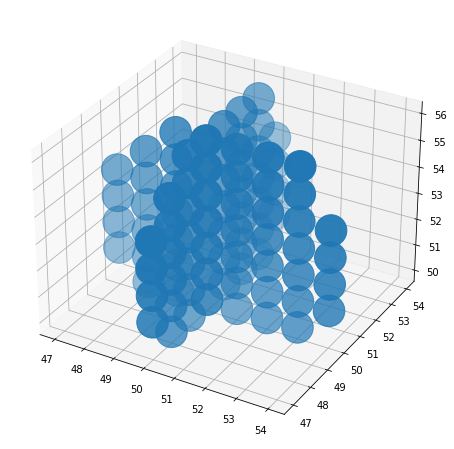

In [3]:
# plant tree in the world
test_world = np.zeros((100,100,100))
test_figure = []

x0,y0,z0 = 50,50,50
for leaf in tree_xz:
    test_world[x0+leaf[1]-trunk,y0,z0+x_max-leaf[0]] = 1
    test_world[x0,y0+leaf[1]-trunk,z0+x_max-leaf[0]] = 1
    test_figure.append((x0+leaf[1]-trunk,y0,z0+x_max-leaf[0]))
    test_figure.append((x0,y0+leaf[1]-trunk,z0+x_max-leaf[0]))

test_figure = np.array(test_figure)
space = 5
fig = plt.figure()
ax = plt.axes(projection="3d")
#plt.title('3D grid map')
fig.set_figwidth(8)
fig.set_figheight(8)
ax.scatter3D(test_figure[:,0],
             test_figure[:,1],
             test_figure[:,2],
             marker='o',
             s = 1000)
             #linewidths=space**2)

In [4]:
test_figure[:,2]

array([56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52,
       52, 52, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
       51, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

# Loading the world

In [5]:
world_folder = 'worlds'
#world_file = 'world_walls.txt'
world_file = 'world_orchard.txt'
with open(os.path.join(world_folder,world_file)) as f:world_source=f.read()
world_source = world_source.splitlines()

line_len = 0
# print loaded map
for line in world_source:
    print(line)
    temp_len = len(line)
    if temp_len > line_len:
        line_len = temp_len
    
start_xy = np.zeros(2)
goal_xy = np.zeros(2)
obstacle_xy = []
world = np.zeros((len(world_source),line_len))
x_min, y_min = 0, 0
x_max, y_max = len(world_source)-1, line_len-1
for i, line in enumerate(world_source):
    for j, char in enumerate(line):
#         print(f"{i},{j}")
        if char == ' ':
            world[i,j] = 0
        elif char == '#':
            world[i,j] = 1
            obstacle_xy.append([i,j])
        elif char == 'o':
            world[i,j] = 2
            start_xy = [i,j]
        elif char == 'x':
            world[i,j] = 3
            goal_xy = [i,j]
obstacle_xy = np.array(obstacle_xy)
obstacle_xy.shape



                                                                                                    
                                                                                                    
                                                                                                    
                                                                                                    
                                                                                                    
                                                                                                    
                                                                                                    
                                                                                                    
                                                                                                    
          #          #          #          #           #           #            #          

(40, 2)

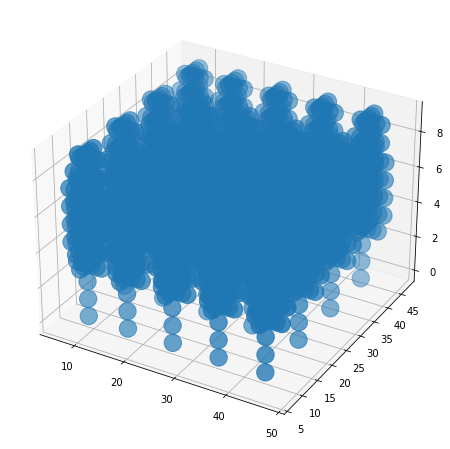

In [6]:
# plant tree in the world
test_world = np.zeros((world.shape[0],world.shape[0],100))
test_figure = []

z0_init = 3
for tree in obstacle_xy:
    x0,y0,z0 = tree[0],tree[1], z0_init
    for leaf in tree_xz:
        if x0+leaf[1]-trunk > test_world.shape[0]-1 or y0 > test_world.shape[1]-1 or z0+tree_max-leaf[0] > test_world.shape[2]-1:
            continue
        if x0 > test_world.shape[0]-1 or y0+leaf[1]-trunk > test_world.shape[1]-1 or z0+tree_max-leaf[0] > test_world.shape[2]-1:
            continue
        test_world[x0+leaf[1]-trunk,y0,z0+tree_max-leaf[0]] = 1
        test_world[x0,y0+leaf[1]-trunk,z0+tree_max-leaf[0]] = 1
        test_figure.append((x0+leaf[1]-trunk,y0,z0+tree_max-leaf[0]))
        test_figure.append((x0,y0+leaf[1]-trunk,z0+tree_max-leaf[0]))
    for z in range(0,z0_init):
        if x0>test_world.shape[0]-1 or y0>test_world.shape[1]-1:
            continue
        test_world[x0,y0,z] = 1
        test_figure.append((x0,y0,z))

test_figure = np.array(test_figure)
space = 5
fig = plt.figure()
ax = plt.axes(projection="3d")
#plt.title('3D grid map')
fig.set_figwidth(8)
fig.set_figheight(8)
ax.scatter3D(test_figure[:,0],
             test_figure[:,1],
             test_figure[:,2],
             marker='o',
             s = 300)
             #linewidths=space**2)

In [7]:
x0+leaf[1]-trunk,y0,z0+tree_max-leaf[0]

(47, 92, 3)

# Map of obstacles to inequivalities

The 3D/2D gridmap of obstacles is converted to the inequivality constraints.

In [8]:
class Obstacles(object):
    """Generates the world populated randomly with obstacles which are intended in form of spheres."""

    def __init__(self, obstacles = None, start = None, goal = None, n_obstacles=None, limits=None, dimmension=None, space=None):
        """Creates world with euclidian space with given size, dimmension and number and size of obstacles.
        """
        
        if obstacles is None:
            
            if dimmension is not None:
                self.dim = dimmension
            else:
                print(f"[WARNING] Dimmension is not specified")
                
            self.n_obstacles = n_obstacles
            self.space = space  # area of the side of the obstacle.
            # size of map
            self.x_min, self.x_max = limits[0:2]
            self.y_min, self.y_max = limits[2:4]
            if self.dim == 3:
                self.z_min, self.z_max = limits[4:6]
                world_grid = [(x, y, z) for x in range(self.x_min, self.x_max, self.space)
                              for y in range(self.y_min, self.y_max, self.space)
                              for z in range(self.z_min, self.z_max, self.space)]  # grid points
            else:
                self.z_min, self.z_max = None, None
                world_grid = [(x, y) for x in range(self.x_min, self.x_max, self.space)
                              for y in range(self.y_min, self.y_max, self.space)]  # grid points
            self.obstacles = np.array(random.sample(world_grid, self.n_obstacles))
        else:
            self.obstacles = obstacles
            self.n_obstacles = obstacles.shape[0]
            self.dim = obstacles.shape[1]
            # size of map
            self.x_min, self.x_max = limits[0:2]
            self.y_min, self.y_max = limits[2:4]
            if self.dim == 3:
                self.z_min, self.z_max = limits[4:6]
            else:
                self.z_min, self.z_max = None, None
            self.space = space

        # left part of inequivality
        self.F = np.tile(A=np.vstack(
            (-np.eye(self.dim, dtype=int), np.eye(self.dim, dtype=int))),
            reps=[self.n_obstacles, 1])
        # right part of inequivality
        obstacles_plus = self.obstacles + self.space
        g_obstacles = np.concatenate((-self.obstacles, obstacles_plus), axis=1)
        self.g = g_obstacles.flatten()

        if goal is not None:
            self.goal = goal
        else:
            if 'world_grid' not in locals():
                if self.dim == 3:
                    self.z_min, self.z_max = limits[4:6]
                    world_grid = [(x, y, z) for x in range(self.x_min, self.x_max, self.space)
                                  for y in range(self.y_min, self.y_max, self.space)
                                  for z in range(self.z_min, self.z_max, self.space)]  # grid points
                else:
                    world_grid = [(x, y) for x in range(self.x_min, self.x_max, self.space)
                                  for y in range(self.y_min, self.y_max, self.space)]  # grid points
            self.goal = np.array(random.sample(world_grid, 1))
            if self.dim == 3:
                # drone goal is on the ground
                self.goal[0, 2] = 1
        
        if start is not None:
            self.start = start
        else:
            if 'world_grid' not in locals():
                if self.dim == 3:
                    self.z_min, self.z_max = limits[4:6]
                    world_grid = [(x, y, z) for x in range(self.x_min, self.x_max, self.space)
                                  for y in range(self.y_min, self.y_max, self.space)
                                  for z in range(self.z_min, self.z_max, self.space)]  # grid points
                else:
                    world_grid = [(x, y) for x in range(self.x_min, self.x_max, self.space)
                                  for y in range(self.y_min, self.y_max, self.space)]  # grid points
            # drone coordinates
            self.start = np.array(random.sample(world_grid, 1))
        if 'world_grid' in locals():
            del(world_grid)

In [9]:
obs = Obstacles(obstacles = obstacle_xy, n_obstacles=10, limits = [-100,100,-100,100,0,100], dimmension=3, space=5)

In [10]:
obs.F

array([[-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0,  1],
       [-1,  0],
       [ 0, -1],
       [ 1,  0